In [1047]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
from scipy import interpolate
import astropy.stats as astro_stats
from scipy.optimize import curve_fit
from astropy.io import ascii

### Model Fitting

In [690]:
X, Y = np.concatenate([x1, x2]), np.concatenate([f1/np.median(f1),
                                                 f2/np.median(f2)])

yerr = abs(np.random.normal(0, 1e-5, len(X)))

In [691]:
import george

In [692]:
from math import gamma
from scipy.special import erf
def ggd(x, mu, alpha, ofs, amp, beta):
    """Generalized Gaussian Distribution modified with an offset term and amplitude to fit the light curves."""
    term_1 = beta/(2*alpha*gamma(1/beta))
    abs_term = ((abs(x-mu))/alpha)**beta
    return amp * term_1 * np.exp(-abs_term) + ofs

In [693]:
t = time
y = mr
yerr = mr_err

In [694]:
from george import kernels

kernel = kernels.ExpKernel(1e22)
gp = george.GP(kernel)
gp.compute(t, yerr)


x_pred = np.linspace(min(t), max(t), 15_500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

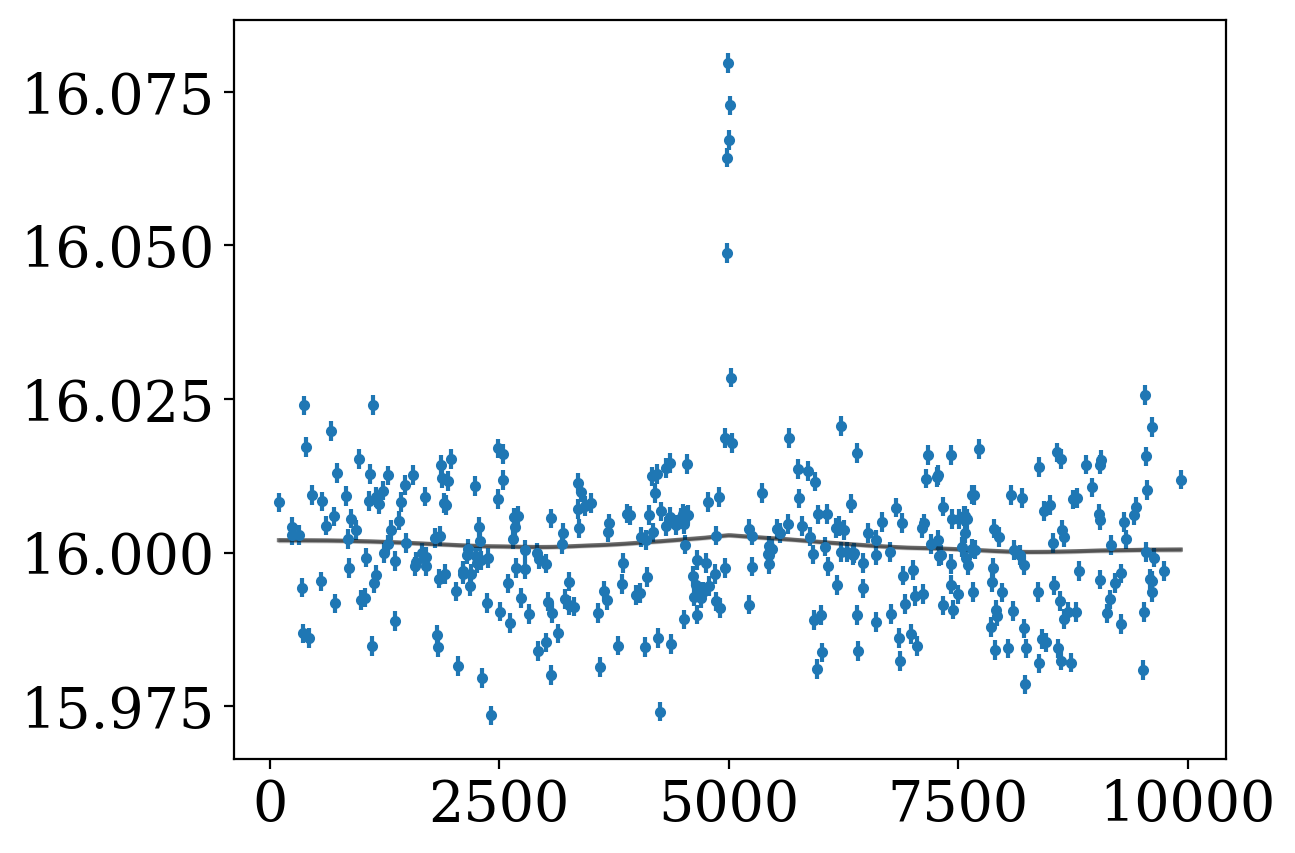

In [695]:
plt.errorbar(t, y, yerr=yerr, fmt='.')

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)


In [699]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -695.4918005298696
        x: [ 2.277e+01]
      nit: 0
      jac: [ 6.586e-06]
 hess_inv: [[1]]
     nfev: 1
     njev: 1

Final ln-likelihood: 695.49


In [700]:
pred, pred_var = gp.predict(y, x_pred, return_var=True)

<ErrorbarContainer object of 3 artists>

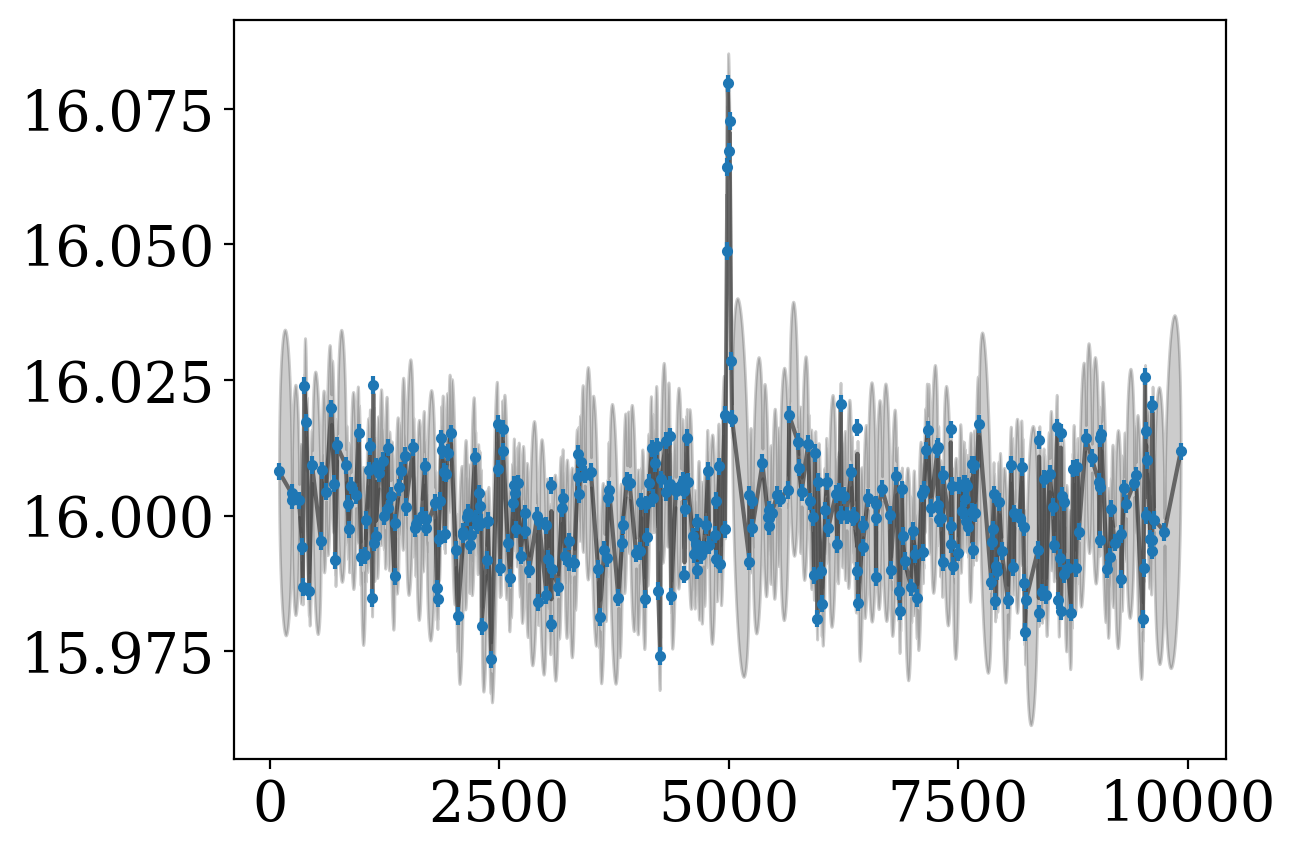

In [705]:
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(t, y, yerr=yerr, fmt='.')



In [1478]:
def deviation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag), astro_stats.biweight_scale(mag)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)    

In [1479]:
pp= window_calculator(x1, f1, x2, f2)

### Generate synthetic `gr`-bandpass data (gaussian bursts)

In [1480]:
N = 350 # number of detections
time = np.random.randint(100, 10_000, N) + np.random.normal(0, 1, N)
ts = np.argsort(time)
time = time[ts]

line = lambda x, a, b: x*a + b
dip = lambda x, a, b, c: a*np.exp(-((x-b)**2)/(2*c**2))

mr = np.zeros(N) + 16 + np.random.normal(0, 0.01, N) + dip(time, 0.1, 5_000, 100) + dip(time, 0.07, 3_000, 100)
mr_err = line(mr, 0.0001, 1e-3)

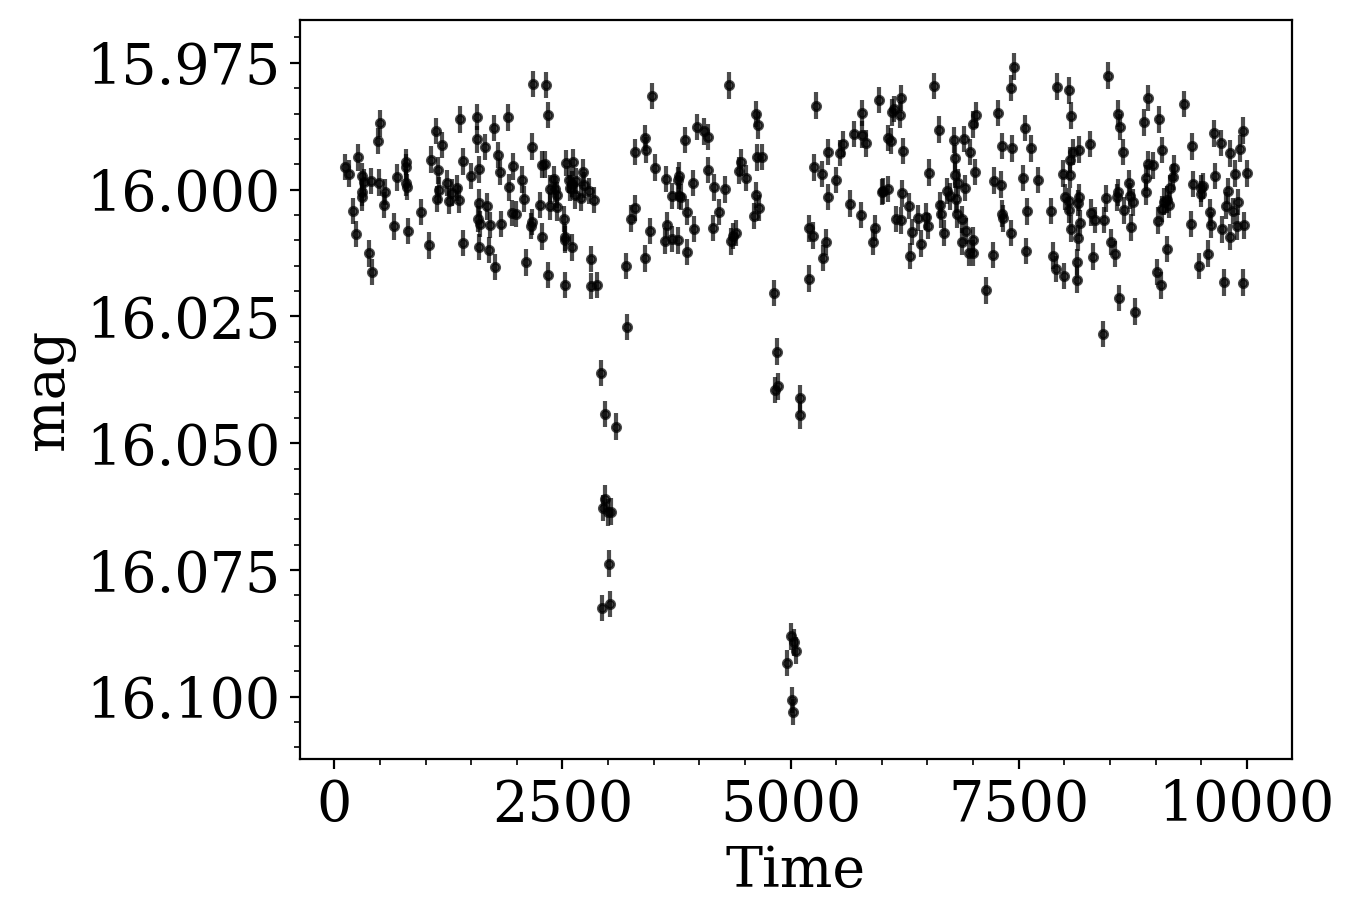

In [1481]:
plt.errorbar(time, mr, yerr=mr_err, fmt='.', color='k', alpha=0.7)
plt.ylim(plt.ylim()[::-1])
plt.ylabel("mag")
plt.xlabel("Time")
plt.minorticks_on()

In [1482]:
dev = deviation(mr, mr_err)

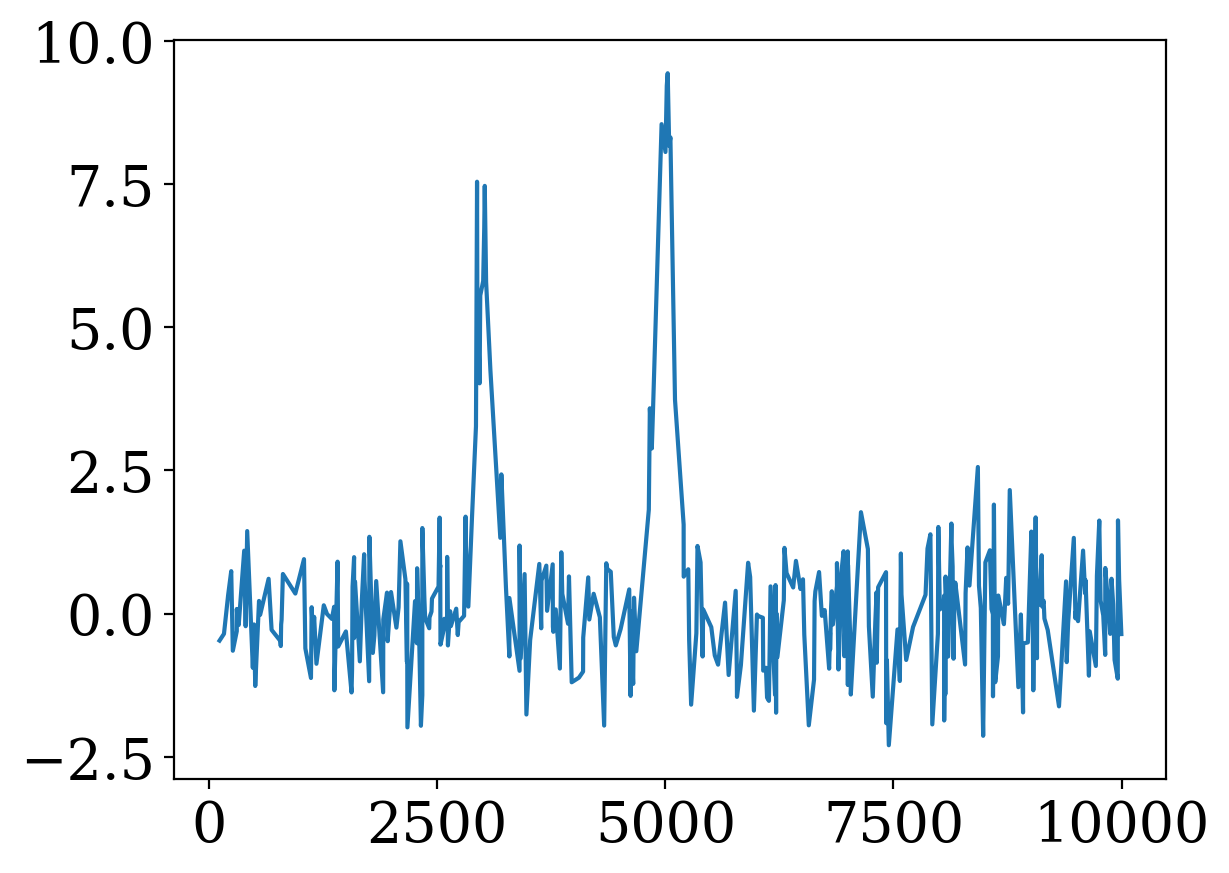

In [1483]:
plt.plot(time, dev)

In [1484]:
from scipy.signal import find_peaks

def calc_dip_edges(xx, yy, _cent, atol=0.2):
    """Crude estimation of the edges of a dipper given the centroid. 
    
      Parameters
      ----------
      xx (array-like): time axis
      yy (array-like): dev
      _cent (float): centroid time 
      atol (float): tolerance to the median. Default is 0.2
    """
    
    indices_forward = np.where((xx > _cent) & np.isclose(yy, np.median(yy), atol=atol))[0]
    t_forward = xx[indices_forward[0]] if indices_forward.size > 0 else 0
    
    indices_back = np.where((xx < _cent) & np.isclose(yy, np.median(yy), atol=atol))[0]
    if indices_back.size > 0:
        t_back = xx[indices_back[-1]]
    else:
        t_back = 0
        
    # Diagnostics numbers
    
    # How many detections above the median thresh in the given window?
    _window_ = (xx>t_back) & (xx<t_forward)
    sel_1_sig = (yy[_window_]>np.median(yy) + np.std(yy)) # detections above 1 sigma
    N_thresh_1 = len((yy[_window_])[sel_1_sig])
    
    return t_forward, t_back, (t_forward-_cent), N_thresh_1


def summarize_dev_dips(times, dips, power_thresh=3, loc_peak_thresh=6):
    
    # Scipy peak finding algorithm
    pks, _ = find_peaks(dips, height=loc_peak_thresh)
    pks = np.sort(pks)[::-1] # sort the reverse peaks
    
    # Time of peaks and dev of peaks
    t_pks, p_pks = times[pks], dips[pks]
    
    # remove peaks that are too close to each other
    t_pks = np.array([t_pks[i] for i in range(-1, len(t_pks)-1) if ~np.isclose(t_pks[i],
                                                                         t_pks[i+1],
                                                                         atol=5)])
    
    p_pks = np.array([p_pks[i] for i in range(-1, len(t_pks)-1) if ~np.isclose(t_pks[i],
                                                                        t_pks[i+1],
                                                                        atol=5)])
    srt = np.argsort(t_pks) # argsort the t_pks
    
    t_pks, p_pks = t_pks[srt], p_pks[srt] # rename variables...
    
    N_peaks = len(t_pks) # number of peaks with removed
    
    # summarize peak information
    dip_summary = {}
    
    i = 0
    for time_ppk, ppk in zip(t_pks, p_pks):
        _edges = calc_dip_edges(times, dips, time_ppk, atol=0.2)
        
        dip_summary[f'dip_{i}'] = {
            "peak_loc": time_ppk,
            'window_start': _edges[0],
            'window_end': _edges[1],
            "N_1sig_in_dip": _edges[-1], 
            'loc_forward_dur': _edges[2],
            "dip_power":ppk
        }
        
        i+=1
    
    return N_peaks, dip_summary

In [1485]:
%%time
r = calc_dip_edges(time, dev, 5014.741729803519, atol=0.2)

CPU times: user 2.62 ms, sys: 1.74 ms, total: 4.36 ms
Wall time: 2.9 ms


In [1486]:
calc_dip_edges(time, dev, 5014.741729803519, atol=0.2)

(5415.092280209989, 4621.794520185566, 400.3505504064706, 12)

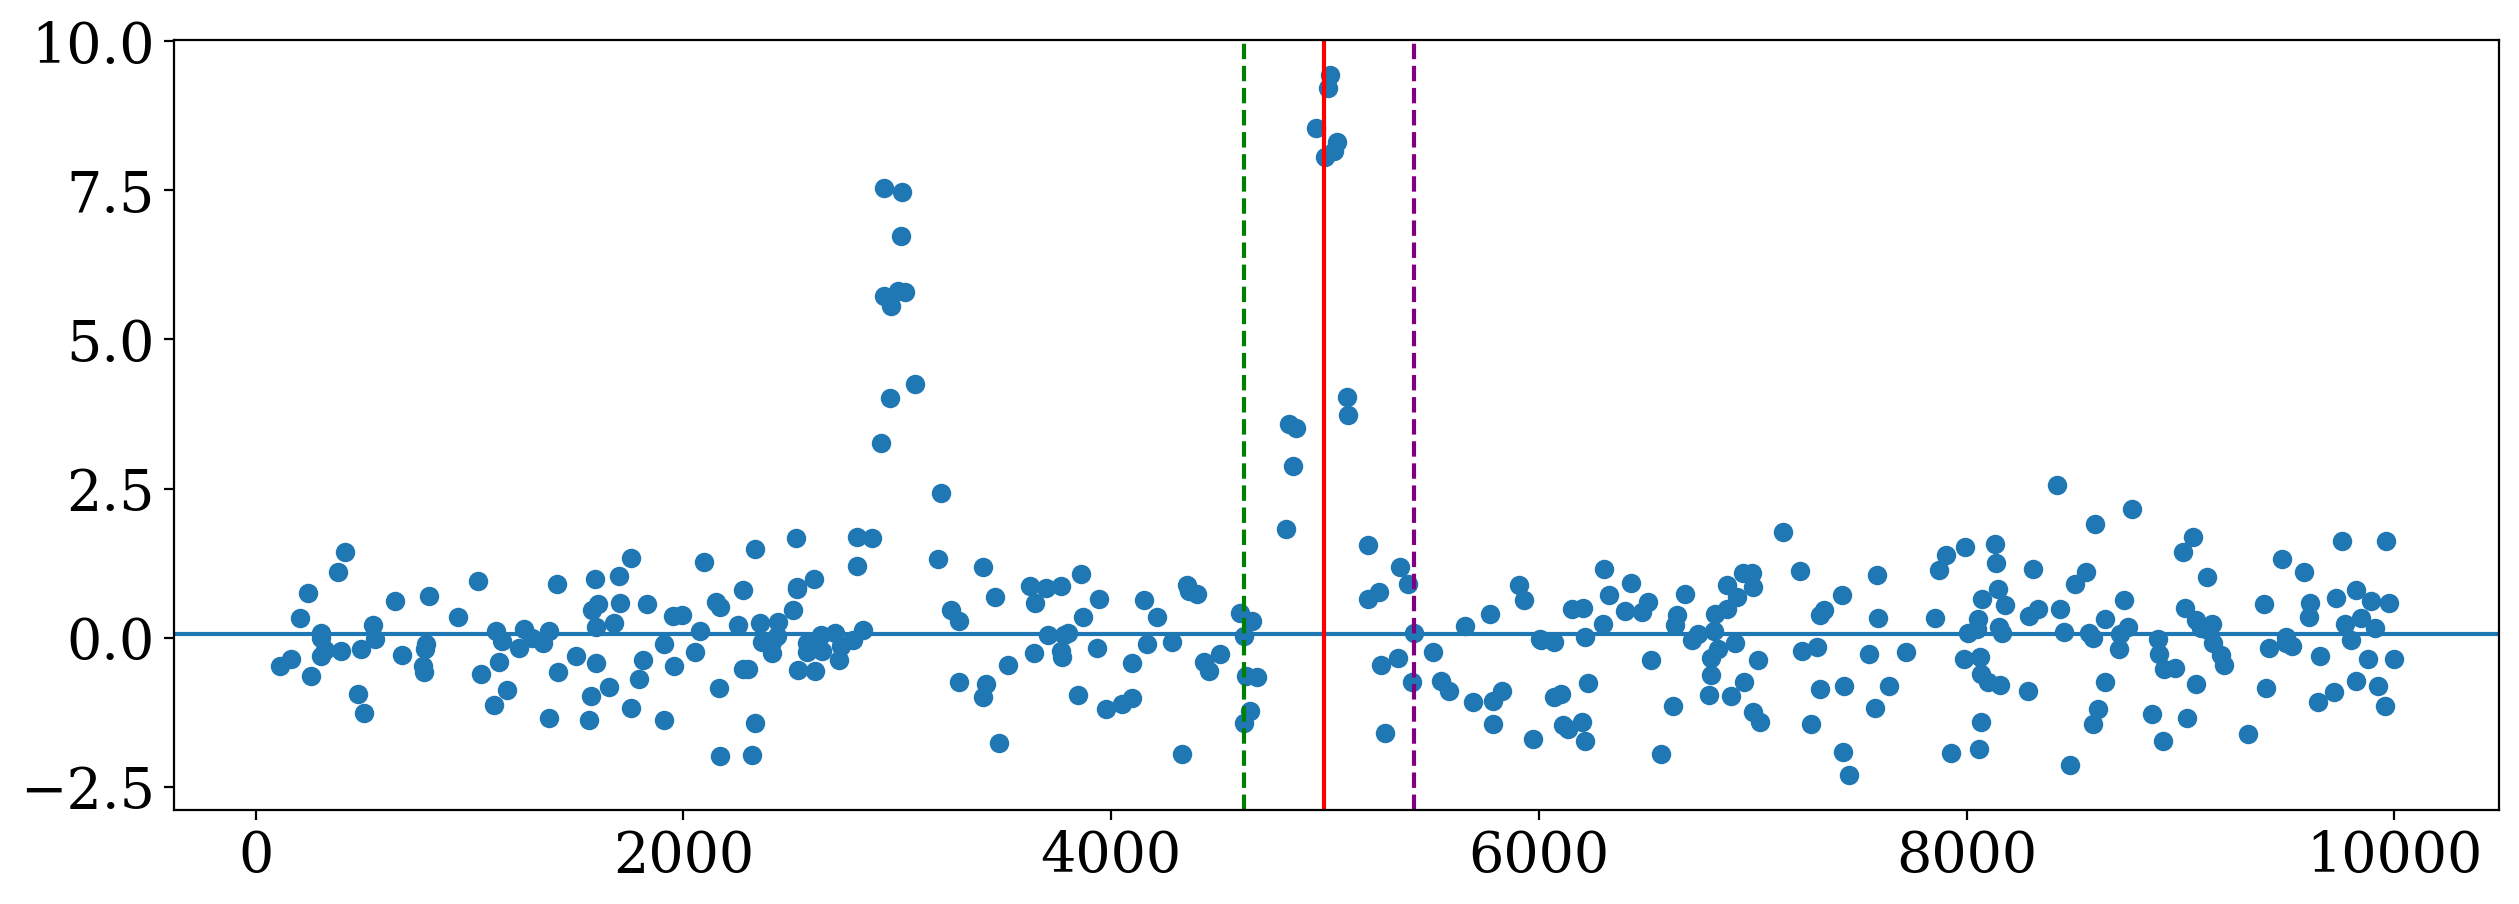

In [1487]:
plt.figure(figsize=(15,5))
plt.scatter(time, dev)
plt.axhline(np.median(dev))
plt.axvline(4996.750603639985, color='red')
plt.axvline(r[0], color='purple', ls='--')
plt.axvline(r[1], color='green', ls='--')




In [1488]:
summarize_dev_dips(time, dev)

(5,
 {'dip_0': {'peak_loc': 2936.5003450362115,
   'window_start': 3704.0683886318748,
   'window_end': 2841.027893660818,
   'N_1sig_in_dip': 11,
   'loc_forward_dur': 767.5680435956633,
   'dip_power': 7.540054981765325},
  'dip_1': {'peak_loc': 3020.9623612807654,
   'window_start': 3704.0683886318748,
   'window_end': 2841.027893660818,
   'N_1sig_in_dip': 11,
   'loc_forward_dur': 683.1060273511093,
   'dip_power': 7.467471233871735},
  'dip_2': {'peak_loc': 4958.985485306014,
   'window_start': 5415.092280209989,
   'window_end': 4621.794520185566,
   'N_1sig_in_dip': 12,
   'loc_forward_dur': 456.10679490397524,
   'dip_power': 8.545386790427623},
  'dip_3': {'peak_loc': 5025.844996726889,
   'window_start': 5415.092280209989,
   'window_end': 4621.794520185566,
   'N_1sig_in_dip': 12,
   'loc_forward_dur': 389.24728348310055,
   'dip_power': 9.434328425833314},
  'dip_4': {'peak_loc': 5055.561269557116,
   'window_start': 5415.092280209989,
   'window_end': 4621.794520185566,
 

In [1489]:
lc = ascii.read("https://ztf.snad.space/dr17/csv/802211300046586")

<ErrorbarContainer object of 3 artists>

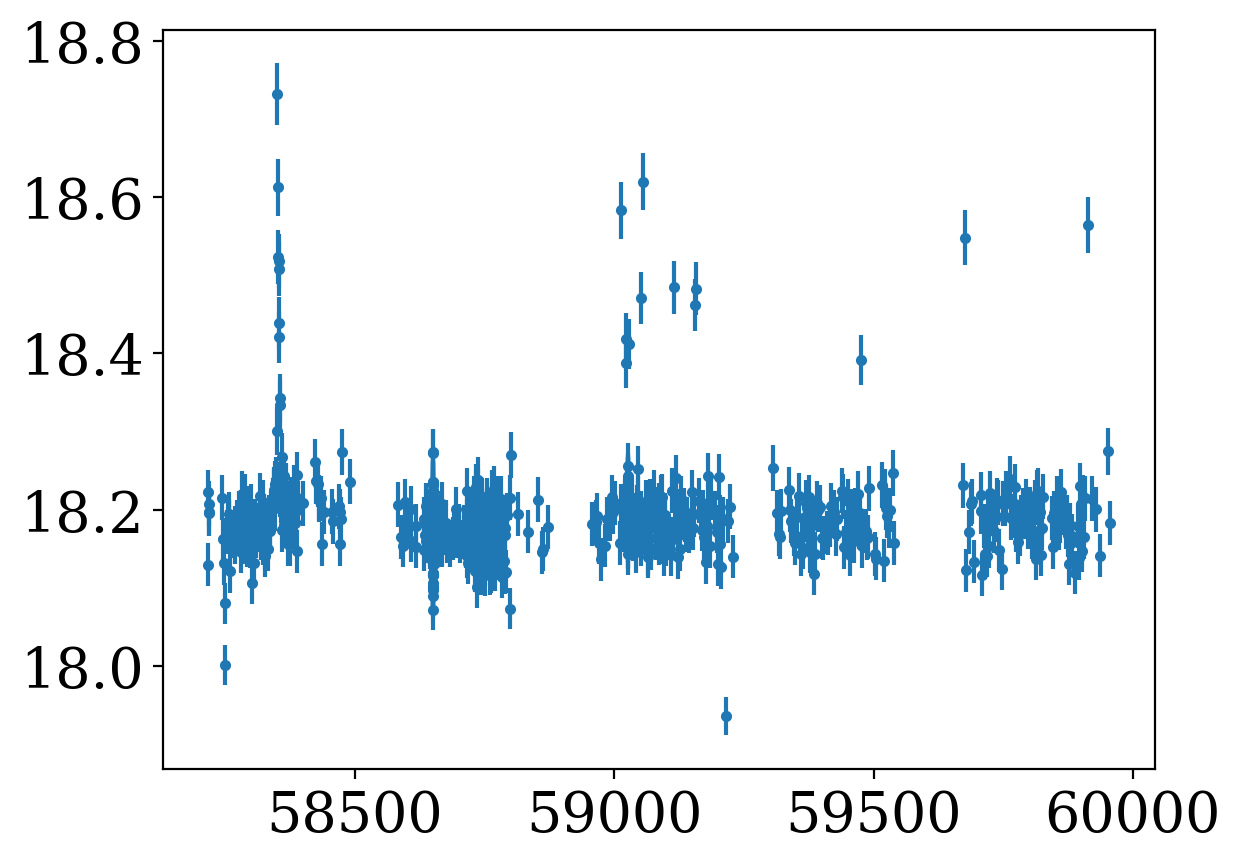

In [1490]:
plt.errorbar(lc['mjd'], lc['mag'], lc['magerr'], fmt='.')

In [1491]:
%%time
info = summarize_dev_dips(lc['mjd'], deviation(lc['mag'], lc['magerr']))

CPU times: user 22.6 ms, sys: 3.26 ms, total: 25.8 ms
Wall time: 22.9 ms


(18.814168784499998, 17.8686755655)

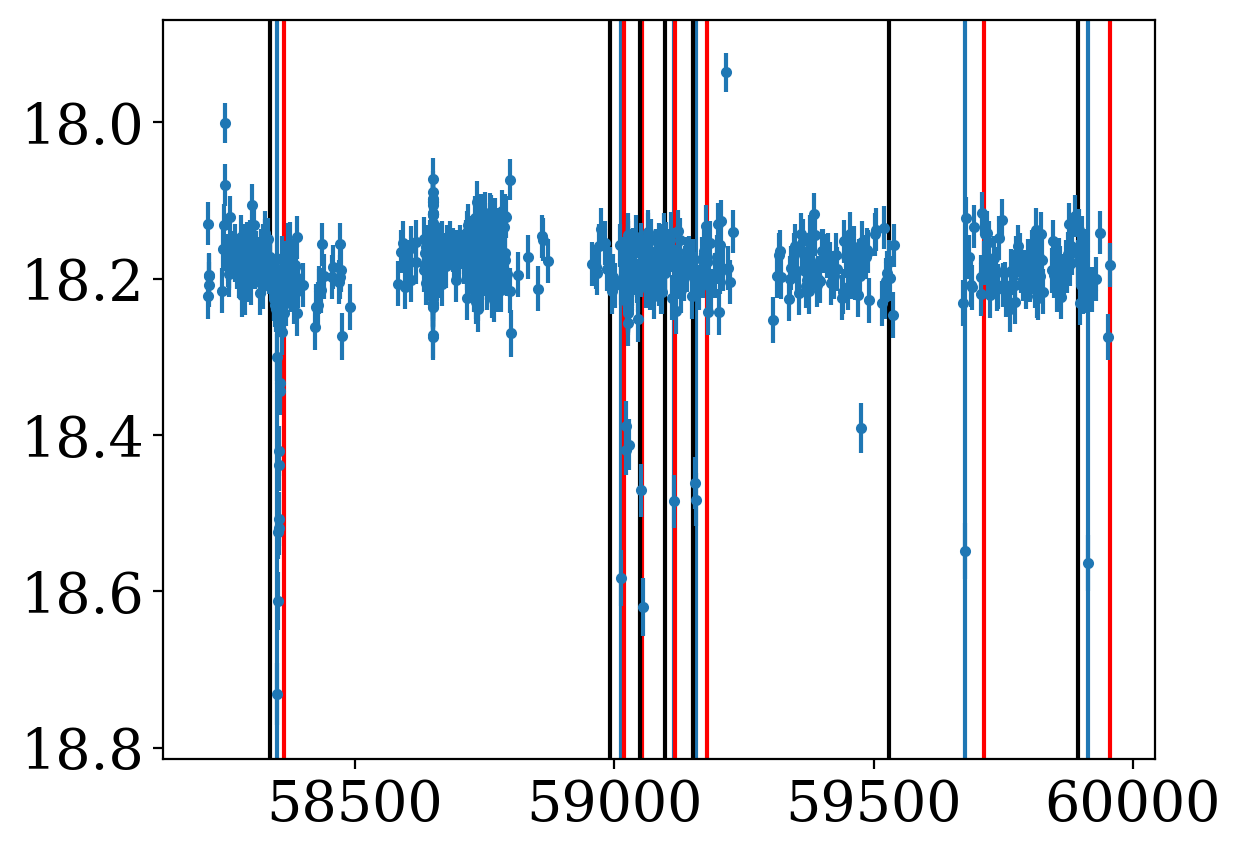

In [1492]:
for i in range(info[0]):
    plt.axvline(info[1][f'dip_{i}']['peak_loc'])
    plt.axvline(info[1][f'dip_{i}']['window_start'], color='red')
    plt.axvline(info[1][f'dip_{i}']['window_end'], color='k')
    
    
plt.errorbar(lc['mjd'], lc['mag'], lc['magerr'], fmt='.')

plt.ylim(plt.ylim()[::-1])

(18.814168784499998, 17.8686755655)

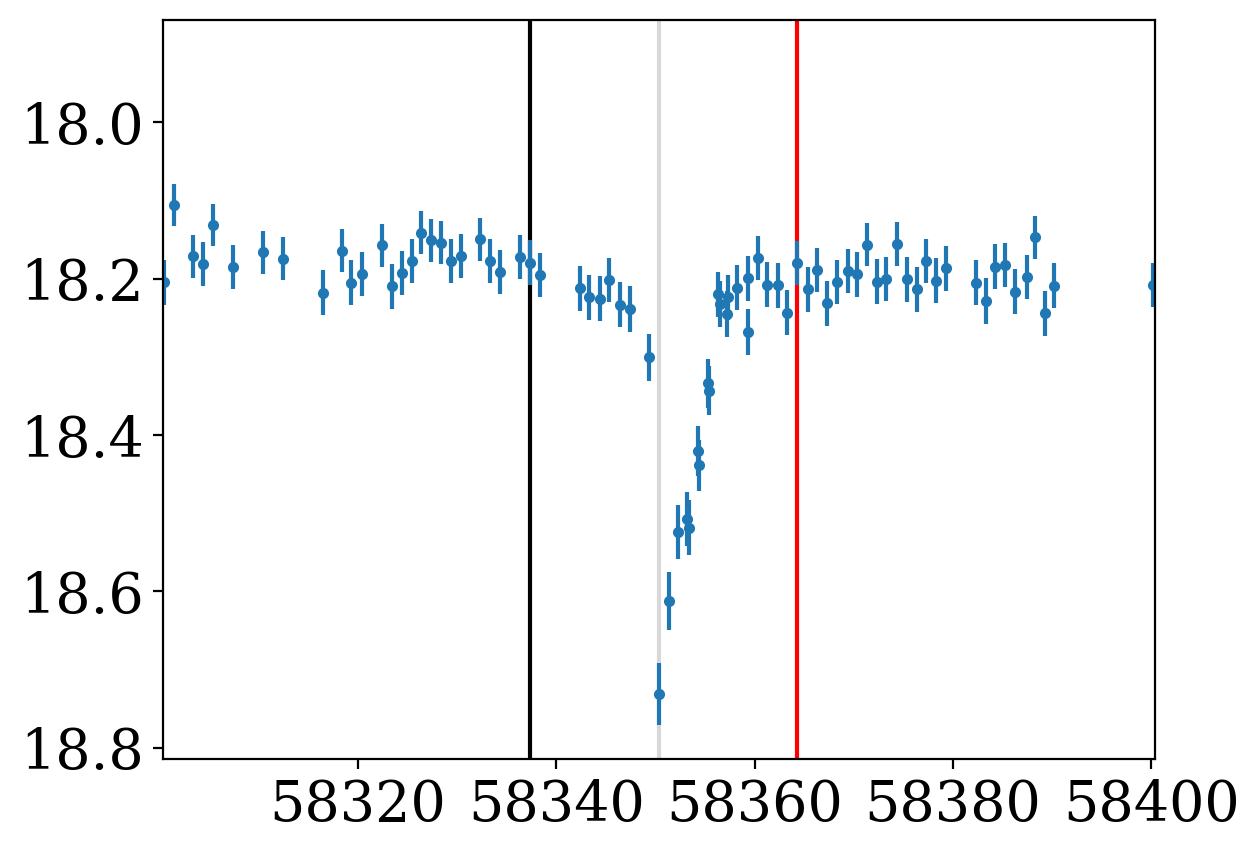

In [1498]:
for i in range(info[0]):
    plt.axvline(info[1][f'dip_{i}']['peak_loc'], color='gray', alpha=0.3)
    plt.axvline(info[1][f'dip_{i}']['window_start'], color='red')
    plt.axvline(info[1][f'dip_{i}']['window_end'], color='k')
        
plt.errorbar(lc['mjd'], lc['mag'], lc['magerr'], fmt='.')
plt.xlim(58350.3775-50, 58350.3775+50)
plt.ylim(plt.ylim()[::-1])

In [1499]:
info

(7,
 {'dip_0': {'peak_loc': 58350.3775,
   'window_start': 58364.30654,
   'window_end': 58337.33468,
   'N_1sig_in_dip': 13,
   'loc_forward_dur': 13.929039999995439,
   'dip_power': 10.867089605138446},
  'dip_1': {'peak_loc': 59013.3413,
   'window_start': 59019.39312,
   'window_end': 58992.45626,
   'N_1sig_in_dip': 1,
   'loc_forward_dur': 6.051820000000589,
   'dip_power': 6.280118898332722},
  'dip_2': {'peak_loc': 59052.38838,
   'window_start': 59054.37285,
   'window_end': 59049.41515,
   'N_1sig_in_dip': 1,
   'loc_forward_dur': 1.984470000003057,
   'dip_power': 9.046814172303026},
  'dip_3': {'peak_loc': 59115.27743,
   'window_start': 59118.2383,
   'window_end': 59098.37321,
   'N_1sig_in_dip': 1,
   'loc_forward_dur': 2.9608699999953387,
   'dip_power': 6.554206680330664},
  'dip_4': {'peak_loc': 59157.11914,
   'window_start': 59179.09526,
   'window_end': 59151.11881,
   'N_1sig_in_dip': 2,
   'loc_forward_dur': 21.976119999999355,
   'dip_power': 6.521336830504153},